In [ ]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import gdown # for downloading from google drive
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import gc
import torch.nn.functional as F

In [ ]:
desired_size = 64
desired_width = desired_height = desired_size

> Note from looking at sample images: I see that normal has high black ratio on top, otherInfection generally has black on the upper part of the lungs and noticeably white on the bottom, COVID has an extremely high proportion of white spots on the lower half and noticeable on the upper half, otherInfection is mostly white but varies more and is not as much as COVID, pneumonia varies but usually has black on top

> From these somewhat noticeable differences, I won't keep my input image size very large, so as to improve model efficiency at not much cost of losing important information. The power of 2 that I like most for this is 64

## Import data

In [ ]:
cwd = os.getcwd()
print(cwd)
# get the current working directory for the following file I/O

/content


In [ ]:
# Modified by Colab AI based on the errors I got using class-provided functions
# that led to img_path being incorrect due to nested folder structures of the zip files
def load_lungXray_data(normal_data_loc, covid_data_loc, pneumonia_data_loc=None, opacity_data_loc=None, img_w=desired_width, img_h=desired_height):
    data = []
    labels = []

    # Load normal images
    for root, _, imgnames in os.walk(normal_data_loc): # use os.walk to handle nested folders
        for imgname in imgnames:
            img_path = os.path.join(root, imgname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_w, img_h))
                # img = img.flatten()
                # remove flattening to preserve image dimensions
                data.append(img)
                labels.append(0)
            else:
                print(f"Warning: Could not load image {img_path}")

    # Load covid images (apply the same fix to other loops)
    for root, _, imgnames in os.walk(covid_data_loc): # use os.walk to handle nested folders
        for imgname in imgnames:
            img_path = os.path.join(root, imgname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_w, img_h))
                # img = img.flatten()
                data.append(img)
                labels.append(1)
            else:
                print(f"Warning: Could not load image {img_path}")

    # Load pneumonia images if the location is provided
    if pneumonia_data_loc is not None:
        for root, _, imgnames in os.walk(pneumonia_data_loc):
            for imgname in imgnames:
                img_path = os.path.join(root, imgname)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (img_w, img_h))
                    # img = img.flatten()
                    data.append(img)
                    labels.append(2)  # Label 2 for pneumonia
                else:
                    print(f"Warning: Could not load image {img_path}")

    # Load opacity images if the location is provided (similar to pneumonia)
    if opacity_data_loc is not None:
        for root, _, imgnames in os.walk(opacity_data_loc):
            for imgname in imgnames:
                img_path = os.path.join(root, imgname)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (img_w, img_h))
                    # img = img.flatten()
                    data.append(img)
                    labels.append(3)  # Label 3 for opacity
                else:
                    print(f"Warning: Could not load image {img_path}")

    return data, labels

In [ ]:
!gdown 1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6 -O covid.zip
!unzip -q covid.zip -d covid

Downloading...
From (original): https://drive.google.com/uc?id=1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6
From (redirected): https://drive.google.com/uc?id=1GuhIclRfMU3iS9XdTFvVR4kZ7tCI8wh6&confirm=t&uuid=7e094bac-5eb6-463e-bc6f-9da71cf5575c
To: /content/covid.zip
100% 130M/130M [00:00<00:00, 311MB/s]


In [ ]:
!gdown 1HBaa9WgG3IHFOUYUjCEch0XPDXXZW5Sz -O normal.zip
!unzip -q normal.zip -d normal

Downloading...
From (original): https://drive.google.com/uc?id=1HBaa9WgG3IHFOUYUjCEch0XPDXXZW5Sz
From (redirected): https://drive.google.com/uc?id=1HBaa9WgG3IHFOUYUjCEch0XPDXXZW5Sz&confirm=t&uuid=c32a6590-acd5-4a3d-b6e6-410c356f3114
To: /content/normal.zip
100% 382M/382M [00:02<00:00, 177MB/s]


In [ ]:
#Downloads a zip file of non-COVID infection radiographs
!gdown 1Hri6AmmgCCH0kdMRgFD_2cqp8Tn30ujk -O otherInfection.zip
#NOTE: this will unzip to a folder named 'images' make sure you RENAME the folder before downloading the next zip
!unzip -q otherInfection.zip -d otherInfection

Downloading...
From (original): https://drive.google.com/uc?id=1Hri6AmmgCCH0kdMRgFD_2cqp8Tn30ujk
From (redirected): https://drive.google.com/uc?id=1Hri6AmmgCCH0kdMRgFD_2cqp8Tn30ujk&confirm=t&uuid=6addda05-e45d-4429-86ff-5c1ac4aa1e28
To: /content/otherInfection.zip
100% 213M/213M [00:14<00:00, 14.9MB/s]


In [ ]:
#Downloads a zip file of viral pneumonia radiographs
!gdown 1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21 -O pneumonia.zip
!unzip -q pneumonia.zip -d pneumonia

Downloading...
From (original): https://drive.google.com/uc?id=1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21
From (redirected): https://drive.google.com/uc?id=1HPtqu6DfIVrIilX8hemjUD5CgGVmGF21&confirm=t&uuid=fdb318bf-ddb1-42e1-abc7-87c97b102055
To: /content/pneumonia.zip
100% 54.5M/54.5M [00:00<00:00, 111MB/s] 


## Check plots for an img_size to choose

In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=desired_size, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)

In [ ]:
def multiclass_plot_digits_with_predictions(model, data, labels, img_size=desired_size, rows=10):
    """
    Plots the images and displays the predicted labels alongside the true labels.
    Modified for multi-class and 3-dimensional data.
    Refactored to accept 'model' as the first parameter.

    Args:
        model: The trained model.
        data: The image data.
        labels: The true labels.
        img_size: The size of the image (assumed square).
        rows: The number of rows for subplots.

    Returns:
        None (plots the images).
    """

    # The following condition is updated for 3-dimensional data
    # Now it only runs once for a single data point
    if data.ndim == 3:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw=dict(xticks=[], yticks=[]))  # Create a single subplot

        im = ax.imshow(data[0], cmap='Greys')  # Display the image (from index 0)

        # Modify the input for the model, removing unnecessary dimension
        output = model(torch.tensor(data[0]).float())
        pred_label = torch.argmax(output).item()  # Get the index of the predicted class
        # print(f"Label: {labels}, Pred label: {pred_label}")
        drawColor = 'black'
        if pred_label != labels:  # Compare the index with the label directly
            drawColor = 'red'
        ax.set_title("label:{}\npred:{}".format(labels, pred_label), color=drawColor)

    else:  # If data is not 3-dimensional, raise an error to be safe
        raise ValueError("Expected 3-dimensional data (batch, height, width)")

In [ ]:
def pretendModel(mydata):
    return torch.tensor(np.zeros((1, 1)))

> Now comparing sizes of 64 and 128 to see which one we like, using the plot_digits_with_predictions function to visualize

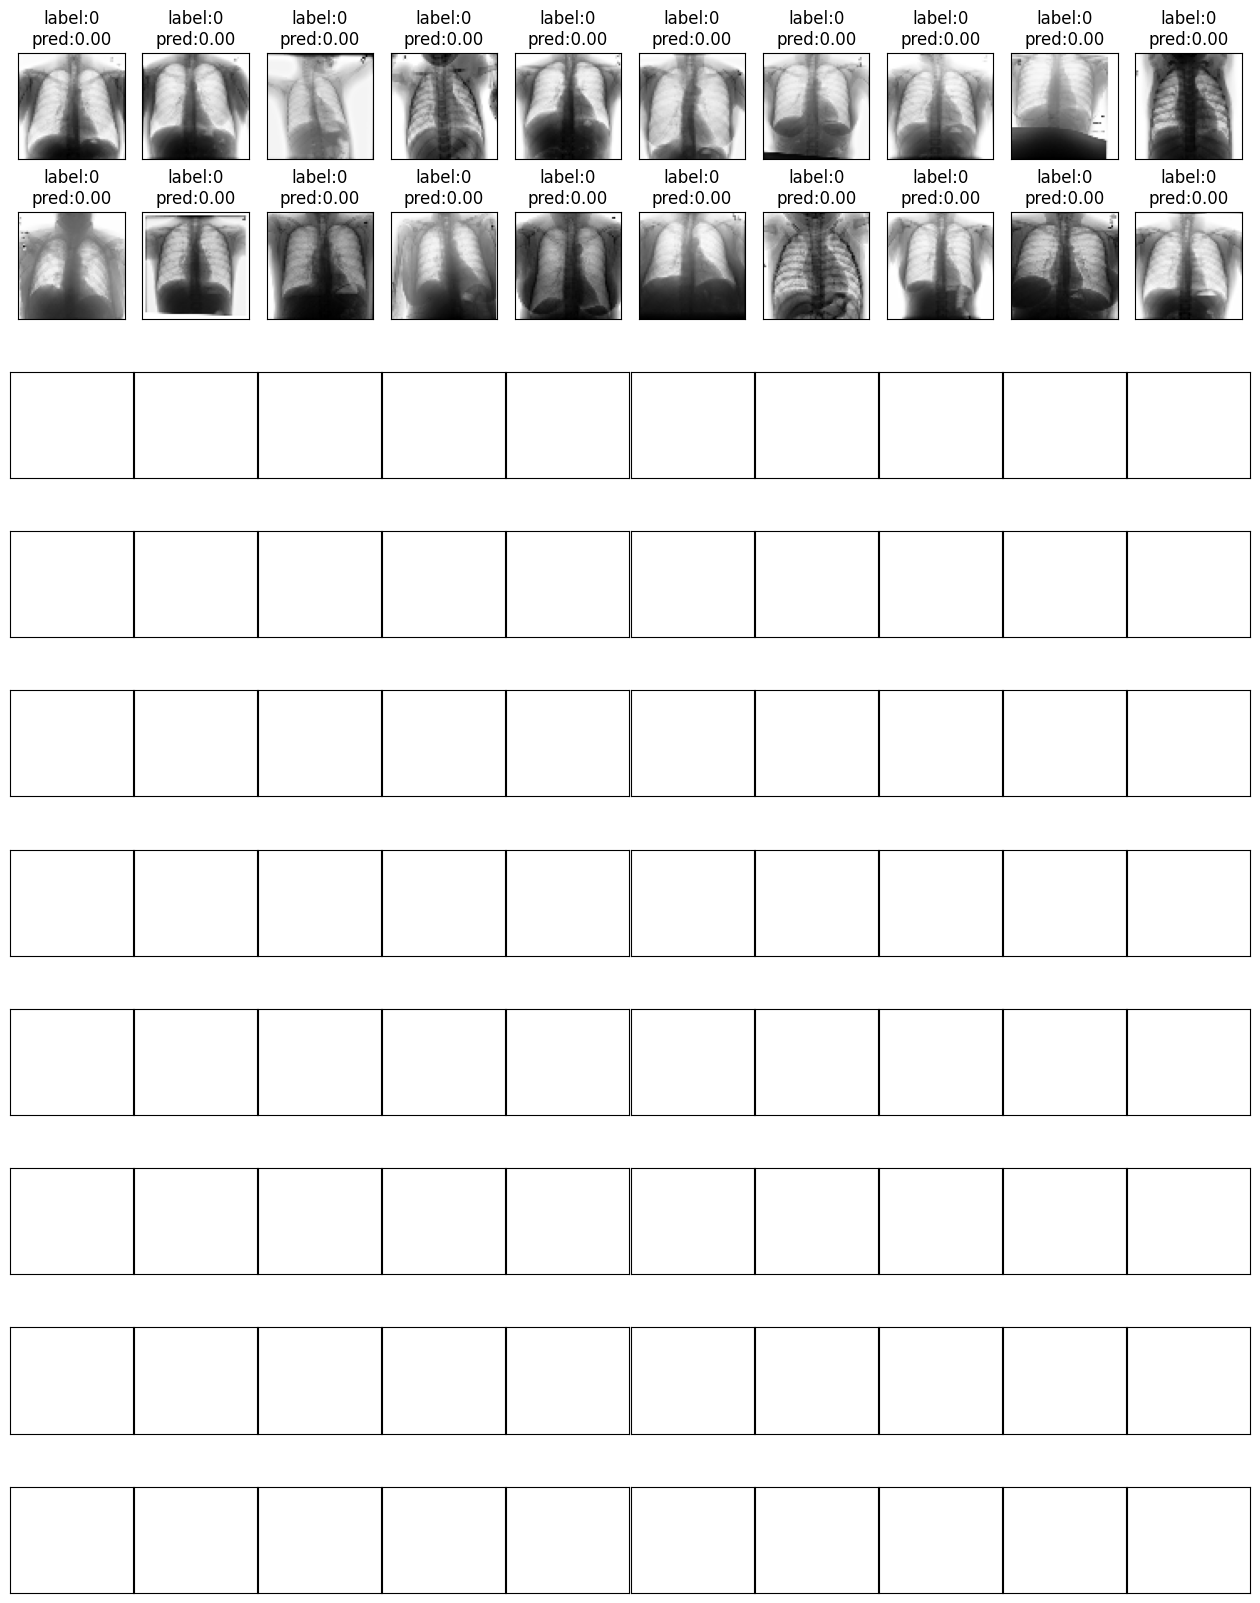

In [ ]:
# First test with test_size (no pun intended) = 64
test_size = 64
data, labels = load_lungXray_data("normal", "covid", "pneumonia", "otherInfection", img_w=test_size, img_h=test_size)
x_test = np.array(data[:20]) # will formally do train-test split later
y_test = np.array(labels[:20]) # same indices to compare the same images
plot_digits_with_predictions(pretendModel, x_test, y_test, img_size=test_size)
print("\n\n")

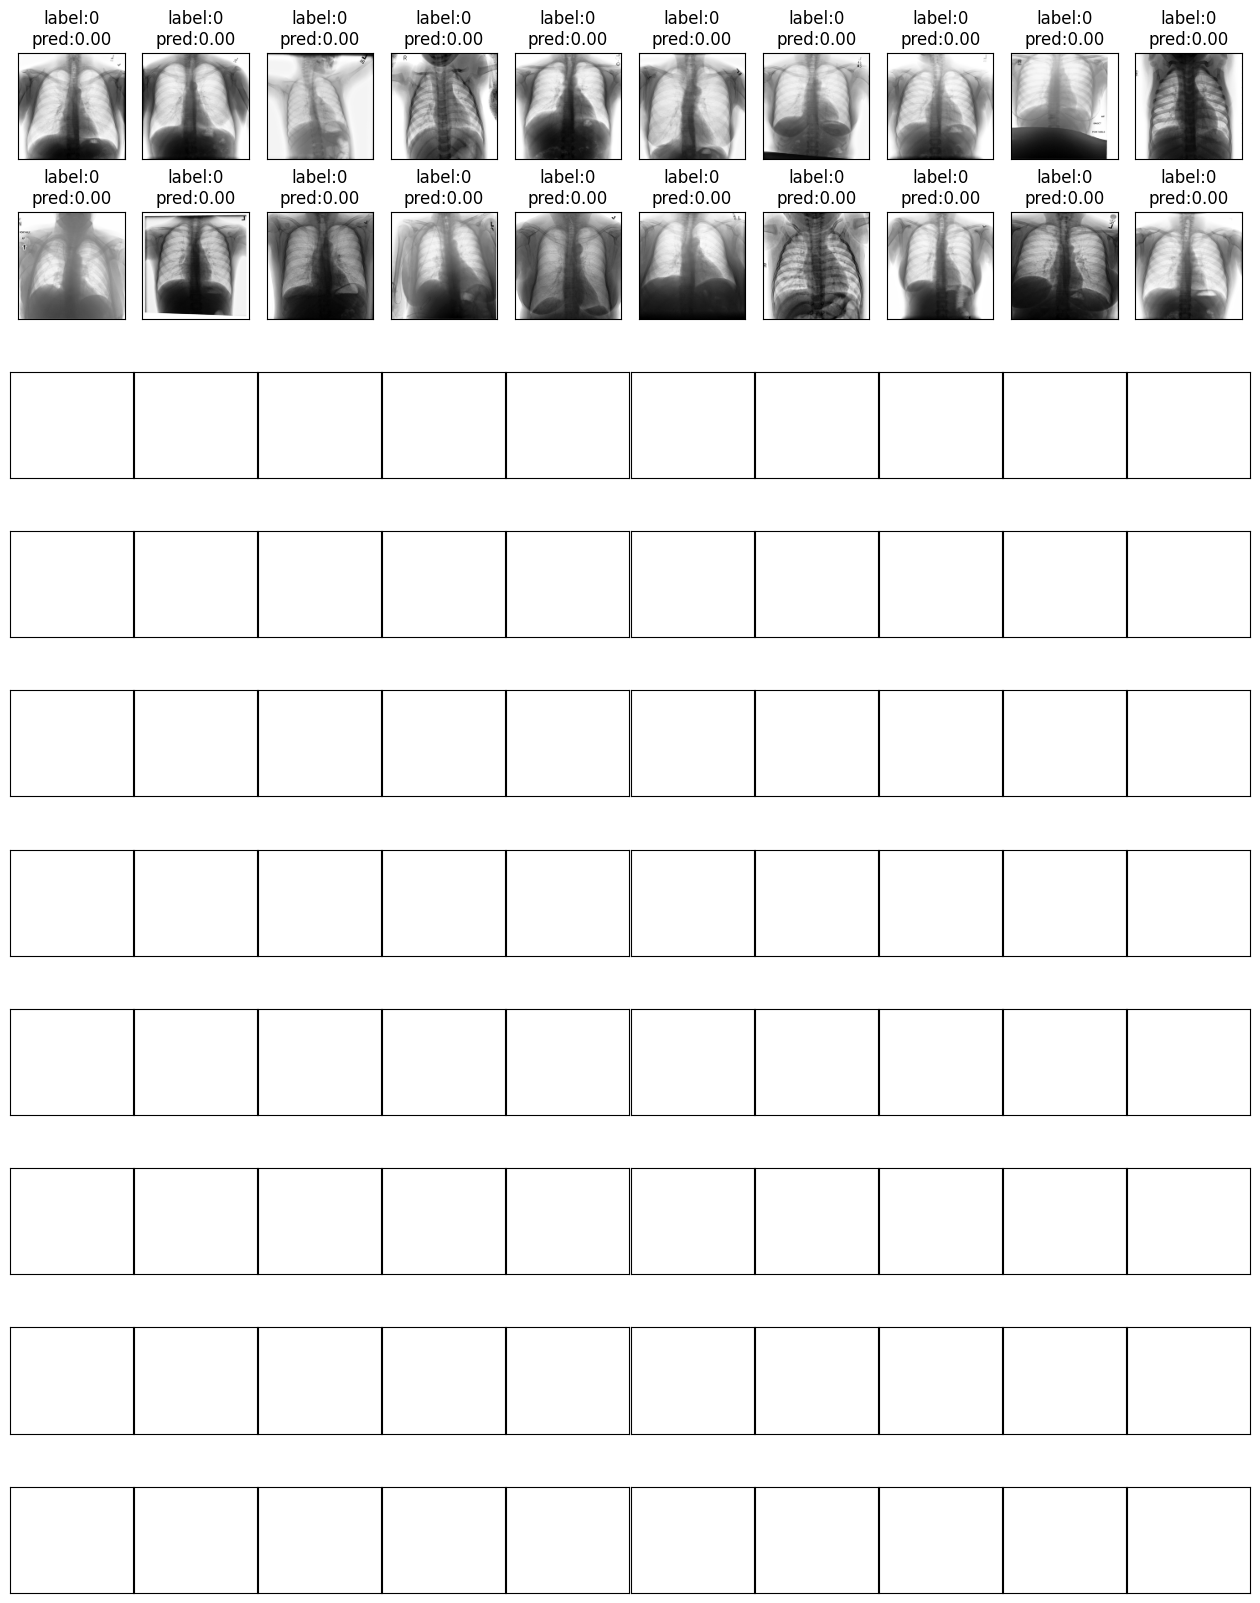

In [ ]:
# Now test with test_size (no pun intended again) = 128
test_size = 128
data, labels = load_lungXray_data("normal", "covid", "pneumonia", "otherInfection", img_w=test_size, img_h=test_size)
x_test = np.array(data[:20])
y_test = np.array(labels[:20])
plot_digits_with_predictions(pretendModel, x_test, y_test, img_size=test_size)
print("\n\n")

In [ ]:
del data, labels
gc.collect()

133487

> The resolutions seem to me to be around the same, so I'll stick with desired_size=64 to be significantly more computationally efficient

In [ ]:
desired_size = 64
desired_width = desired_height = desired_size
# Just for readability

> Now to define functions and classes using a decided desired_size, desired_width, and desired_height as default parameters

## Define helper functions (binary)

In [ ]:
# Redefine plot_digits_with_predictions to use the new desired_size default value for img_size
# In case it is different from the default value in the original definition
def plot_digits_with_predictions(model, data, labels, img_size=desired_size, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)

In [ ]:
def train(model,  data_generator, loss_function, optimizer): # copied from class day 19
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch

    prediction = model(input_data)                   # Forward pass: compute the output class given a image

    # Reshape target_output to have the same shape as the prediction
    target_output = target_output.view(prediction.shape)

    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

In [ ]:
def AIC_BIC_BCEwithLogitsLoss(model, data_loader, loss_function):
    model.eval()
    total_nll = 0 # the sum of the NLLs over all batches
    total_num_samples = 0 # the sum of the number of samples accounted for

    with torch.no_grad():
        for inputs, targets in data_loader:
            # inputs, targets = inputs.to(model.device), targets.to(model.device)
            outputs = model(inputs)
            # loss = loss_function(output, target).item()
            # total_loss += loss * len(target) # Assuming batch size is not always the same
            mean_loss = loss_function(outputs, targets).item()
            batch_size = inputs.size(0)
            total_nll += mean_loss * batch_size
            total_num_samples += batch_size

    # Get the number of trainable parameters in the model
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Calculate AIC and BIC
    aic = 2 * num_params - 2 * total_nll
    bic = num_params * np.log(total_num_samples) - 2 * total_nll

    return aic, bic

# Ideally we have the lowest possible AIC and BIC

In [ ]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  return test_loss

In [ ]:
def manual_train_test_split(X, y, test_proportion):
    X = np.array(X)  # Convert the list of images to a NumPy array
    y = np.array(y)

    num_samples = y.shape[0]  # Get the total number of samples
    split_point = int((1 - test_proportion) * num_samples)  # Calculate the split point

    # Create a random permutation of indices
    shuffled_indices = np.random.permutation(num_samples)

    # Use the shuffled indices to split the data
    X_train = X[shuffled_indices[:split_point]]
    y_train = y[shuffled_indices[:split_point]]
    X_test = X[shuffled_indices[split_point:]]
    y_test = y[shuffled_indices[split_point:]]

    # Reshape y_train and y_test to have an extra dimension
    y_train = np.expand_dims(y_train, 1)
    y_test = np.expand_dims(y_test, 1)

    return X_train, X_test, y_train, y_test

In [ ]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

And lastly, `graphLoss()` graphs the testing and training loss versus the number of epochs.

In [ ]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

Finally, we pull everything together in the function `trainAndGraph()`. This function creates arrays to store the loss values, calls the `train()` and `test()` functions on the network model, and runs the final trained model on all the data for analysis. We also use the helper functions above to graph the results of the model and plot the loss over time.

In [ ]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1, verbose=False):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    if (verbose==True): print("Results logged")

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

As this is a classification problem, we'd like to be able to compute the accuracy of our `model`. The below code assumes that if the prediction is positive, we are predicting class `1`; otherwise, the prediction should be interpreted as class `0`.

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
def computeLabelAccuracyWithData(model, training_generator, testing_generator):
  computeLabelAccuracy(model, training_generator, "Training Accuracy")
  computeLabelAccuracy(model, testing_generator, "Test Accuracy")

In [ ]:
def get_nonlinear_transforms(img_size):
  nonlinear_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
  ])
  nonlinear_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
  ])
  return nonlinear_train_transform, nonlinear_test_transform

In [ ]:
def get_linear_transforms(img_size):
  # remove non-linear transforms from get_transforms to work with linear classifiers
  linear_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
  ])
  linear_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
  ])
  return linear_train_transform, linear_test_transform

In [ ]:
def fullTrainModel(model, training_dataset, testing_dataset, loss_function, learning_rate, optimizer_type="AdamW", num_epochs=20, print_interval=5, batch_size=64, weight_decay=1e-3, verbose=False, print_aic_bic=True, print_accuracies=True):
  # can lower print_interval to 1 or 2 when trying to decide models to train
  if (optimizer_type == "AdamW"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif (optimizer_type == "Adam"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    if (optimizer_type != "SGD"):
      print(f"Optimizer of type {optimizer_type} not supported. Using SGD")
  training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
  testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)
  trainAndGraph(model, training_loader, testing_loader, loss_function, optimizer, num_epochs, learning_rate, print_interval, verbose)
  if (print_aic_bic):
    aic, bic = AIC_BIC_BCEwithLogitsLoss(model, training_loader, loss_function)
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")
  if (print_accuracies): computeLabelAccuracyWithData(model, training_loader, testing_loader)

> Transforms are used here to help prevent overfitting when it becomes a problem. This is by increasing the size and variety of the training dataset and helping the model recognize patterns that are not dependent on irrelevant features like small transformations or positions of certain features in the training data. This not only helps generalize to patterns on unseen data but also helps with outliers (such as if there are errors in the image-taking process and translations or image angles are unusually large)

> This also helps to account for variations in the image geometries such as horizontal flips and, furthermore for nonlinear transformations, rotations or translations.

> Finally, I noticed that transforms are very common in image classification and object detection tasks.

In [ ]:
def SigmoidLoss(output, target):
  loss = torch.mean((torch.sigmoid(output) - target)**2)
  return loss

## Define helper functions (multiclass)

In [ ]:
multiclass_loss_function = nn.CrossEntropyLoss()

In [ ]:
# Redefine train for multiclass classification by removing the reshaping of target_output
def multiclass_train(model, data_generator, loss_function, optimizer):
  model.train()
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()
    prediction = model(input_data)
    # target_output = target_output.view(prediction.shape)  # This line is removed
    loss = loss_function(prediction, target_output.long())  # Convert target to long
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss / num_batches

In [ ]:
# Redefine test for multiclass classification by removing reshaping of prediction
def multiclass_test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      # Removed the reshaping of the prediction
      num_batches += 1
  test_loss /= num_batches
  return test_loss

In [ ]:
# Redefine trainAndGraph for multiclass classification
def multiclass_trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1, verbose=False):
  train_loss_history = []
  test_loss_history = []
  epoch_counter = []
  for epoch in range(num_epochs):
    avg_train_loss = multiclass_train(model, training_generator, loss_function, optimizer)
    avg_test_loss = multiclass_test(model, testing_generator, loss_function)
    train_loss_history.append(avg_train_loss)
    test_loss_history.append(avg_test_loss)
    epoch_counter.append(epoch)
    if (verbose==True): print("Results logged")
    print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, avg_train_loss, avg_test_loss))

  graphLoss(epoch_counter, train_loss_history, test_loss_history)


In [ ]:
# AIC and BIC for CrossEntropyLoss
def AIC_BIC_CrossEntropyLoss(model, data_loader, loss_function):
    model.eval()
    total_nll = 0  # Total negative log-likelihood
    total_num_samples = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            # Calculate loss using CrossEntropyLoss
            loss = loss_function(outputs, targets.long()).item()
            # now we need long to match the type needed for CrossEntropyLoss
            batch_size = inputs.size(0)
            total_nll += loss * batch_size  # Accumulate NLL
            total_num_samples += batch_size

    # Get the number of trainable parameters in the model
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Calculate AIC and BIC
    aic = 2 * num_params + 2 * total_nll  # Note: '+' instead of '-' for NLL
    bic = num_params * np.log(total_num_samples) + 2 * total_nll  # '+' instead of '-'

    return aic, bic

In [ ]:
def multiclass_computeLabelAccuracy(model, data_loader, label_text="", return_accuracy=False):
  model.eval() # Set the model to evaluation mode
  correct = 0
  total=0

  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted==target).sum().item()

  accuracy = correct / total
  accuracy_percent = 100 * accuracy
  # print(f"\n{label_text}: Accuracy: {correct}/{total} ({accuracy:.1f}%)")
  if (not return_accuracy):
    print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
      label_text, correct, len(data_loader.dataset), accuracy_percent))
  else:
    return accuracy

In [ ]:
def multiclass_computeLabelAccuracyWithData(model, training_generator, testing_generator):
  multiclass_computeLabelAccuracy(model, training_generator, "Training Accuracy")
  multiclass_computeLabelAccuracy(model, testing_generator, "Test Accuracy")

In [ ]:
# redefine fullTrainModel for multiclass classification
def multiclass_fullTrainModel(model, training_dataset, testing_dataset, loss_function, learning_rate, optimizer_type="AdamW", num_epochs=20, print_interval=5, batch_size=64, weight_decay=1e-3, print_aic_bic=True, print_accuracies=True, verbose=False):
  if optimizer_type == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_type == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    if (optimizer_type != "SGD"):
      print(f"Optimizer of type {optimizer_type} not supported. Using SGD")
  training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
  testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)
  print("Data loaded")
  multiclass_trainAndGraph(model, training_loader, testing_loader, loss_function, optimizer, num_epochs, learning_rate, print_interval, verbose)
  if (print_aic_bic):
    aic, bic = AIC_BIC_CrossEntropyLoss(model, training_loader, loss_function)
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")
  if (print_accuracies): multiclass_computeLabelAccuracyWithData(model, training_loader, testing_loader)

## Helper classes

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array, transform=None, multiclass=False):
    # add an extra dimension to the output tensor if it's 1-dimensional
    if target_output_array.ndim == 1:
      target_output_array = np.expand_dims(target_output_array, 1)

    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()

    self.output_tensor = torch.from_numpy(target_output_array).float()
    self.transform = transform
    self.multiclass = multiclass

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def set_transform(self, transform):
    self.transform = transform

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      if (self.multiclass):
        y = self.output_tensor[index].long().squeeze() # Multi-class format
        y = y.item() if y.dim() == 0 else y # add this to remove extra dimension from tensor
      else:
        y = self.output_tensor[index] # For binary classification

      # Apply the transformation to resize the image
      if (self.transform is not None):
        # print("Transforming")
        X = self.transform(X)
        # print("Done transforming")
      X = X.view(-1)

      return X, y

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)
        # self.flatSize means take our input shape and map it to our output shape

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)
        # x = torch.sigmoid(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self, img_w, img_h, numClasses=1, dropout_probability=0.5):
        super(CNN, self).__init__()
        self.img_w = img_w
        self.img_h = img_h
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Calculate the size of the flattened features after convolutions and pooling
        # Assuming img_w and img_h are divisible by 4 (due to two pooling layers)
        self.flattened_size = 64 * (img_w // 4) * (img_h // 4)
        self.fc = nn.Linear(self.flattened_size, numClasses)
        # Add a dropout layer
        self.dropout = nn.Dropout(dropout_probability)

    def forward(self, x):
        x = x.view(-1, 1, self.img_w, self.img_h)  # Reshape with img_w and img_h
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, self.flattened_size)  # Flatten for fully connected layer
        # Dropout before the fully-connected layer
        x = self.dropout(x)

        x = self.fc(x)
        return x

In [ ]:
class HealthyCNN(nn.Module):
    def __init__(self, img_size=desired_size, num_classes=1, dropout_probability=0.7):
        super(HealthyCNN, self).__init__()
        self.img_size = img_size
        self.num_classes = num_classes
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 32x64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 128x8x8
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * (img_size//8 if (img_size//8 > 0) else 1) * (img_size//8 if (img_size//8 > 0) else 1), 256),
            nn.ReLU(),
            nn.Dropout(dropout_probability),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(-1, 1, self.img_size, self.img_size)  # Reshape with img_size
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [ ]:
# Creating a MulticlassCNN that inherits from CNN with default numClasses changed
# With this, if I ever need to change more things with MulticlassCNN, I can do that easily
class MulticlassCNN(CNN):
  def __init__(self, img_w, img_h, numClasses=4, dropout_probability=0.5):
    super().__init__(img_w, img_h, numClasses=numClasses, dropout_probability=dropout_probability)

  def forward(self, x):
    x = super().forward(x) # performs the convolutional and fully-connected operations
    # print(f"Shape of x before returning: {x.shape}")
    return x


## Loading the data, removing outliers (based on sum of pixel values per image), then normalizing the data

In [ ]:
data, labels = load_lungXray_data("normal", "covid", "pneumonia", "otherInfection", img_w=desired_width, img_h=desired_height)

In [ ]:
x_train, x_test, y_train, y_test = manual_train_test_split(data, labels, test_proportion=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16932, 64, 64)
(16932, 1)
(4233, 64, 64)
(4233, 1)


> z-score normalize my X data so that it includes negative values, thus balancing out function activations in neural networks. This way, I can also track outliers (z-score < -3 or > 3) and remove them, which I can't do with min-max scaling alone

> To filter outliers, I will choose outliers as those with mean pixel-values (since they're originally 0 to 255) ≥ 3 standard deviations away from the mean over all the images

> I feel pixel sums are an okay metric to filter based on, since the samples I feel most odd about are those that are extremely white or black all around

In [ ]:
x_train_sums = np.sum(x_train, axis=(1, 2)) # per-image sum of pixel values of train images
global_mean = np.mean(x_train_sums) # global mean of per-image sums
global_std = np.std(x_train_sums) # global std of per-image sums

x_test_sums = np.sum(x_test, axis=(1, 2)) # per-image sum of pixel values of test images

outlier_train_indices = np.where(np.abs((x_train_sums - global_mean) / global_std) > 3)
outlier_test_indices = np.where(np.abs((x_test_sums - global_mean) / global_std) > 3)

In [ ]:
print(len(outlier_train_indices[0]))
print(len(outlier_test_indices[0]))
x_train = np.delete(x_train, outlier_train_indices, axis=0)
y_train = np.delete(y_train, outlier_train_indices, axis=0)
x_test = np.delete(x_test, outlier_test_indices, axis=0)
y_test = np.delete(y_test, outlier_test_indices, axis=0)

62
13


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16870, 64, 64)
(16870, 1)
(4220, 64, 64)
(4220, 1)


In [ ]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

In [ ]:
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std
# to convert x_train back to the original state, multiply by the global stored variables x_train_std and add x_train_mean

In [ ]:
# Checking if normalization was done correctly
print(np.mean(x_train))
print(np.std(x_train))
print(np.mean(x_test))
print(np.std(x_test))


-1.023748036222225e-16
0.999999999999999
-0.003993182465491472
0.996692000232015


> To convert x_train and x_test back to their original states, multiply by x_train_std and add x_train_mean (both global variables from the previous cell)

In [ ]:
del data, labels
gc.collect()

41

In [ ]:
training_dataset = NumpyDataset(x_train, y_train, transform=None)
testing_dataset = NumpyDataset(x_test, y_test, transform=None)

## Exploratory Data Analysis

> Remember from our load_lungXray_data function above that label=0 corresponds to normal, label=1 corresponds to COVID, label=2 corresponds to otherInfection and label=3 corresponds to pneumonia

In [ ]:
unique_labels, label_counts = np.unique(y_train, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Number of training samples with label {label}: {count}")

Number of training samples with label 0: 8162
Number of training samples with label 1: 2917
Number of training samples with label 2: 1087
Number of training samples with label 3: 4704


> We see here that none of the labels are really underrepresented except maybe label 2, IE we might have to do data balancing on that when we go to disease-specific classification

> For healthy or not healthy, I don't see the need for data balancing since there are around the same number of samples with label 0 as there are with labels 1, 2, and 3 combined

## Problem 1 (Healthy vs Unhealthy w/ Neural Networks)

In [ ]:
del x_train, x_test, y_train, y_test
# save RAM; will use dataset.input_tensor for x train/test and dataset.output_tensor for y train/test
gc.collect()

0

In [ ]:
linear_train_transform, linear_test_transform = get_linear_transforms(desired_size)

In [ ]:
nonlinear_train_transform, nonlinear_test_transform = get_nonlinear_transforms(desired_size)

In [ ]:
# Make a y_train_healthy with 1s for samples of any of the 3 unhealthy types and 0 for healthy samples
y_train_binary = np.zeros(len(training_dataset.output_tensor))
y_train_binary[training_dataset.output_tensor[:, 0] != 0] = 1
y_test_binary = np.zeros(len(testing_dataset.output_tensor))
y_test_binary[testing_dataset.output_tensor[:, 0] != 0] = 1

In [ ]:
# make train and test sets with 1s for all non-0 labels
training_dataset_binary = NumpyDataset(training_dataset.input_tensor.numpy(), y_train_binary, transform=None)
testing_dataset_binary = NumpyDataset(testing_dataset.input_tensor.numpy(), y_test_binary, transform=None)

In [ ]:
# Just to compare and make sure our datasets are initialized correctly
# Get the number of samples in our training_dataset tensor with label == 0 and != 0
num_training_samples_with_label_0 = (training_dataset.output_tensor == 0).sum().item()
num_training_samples_with_label_nonzero = (training_dataset.output_tensor != 0).sum().item()
print(f"Number of training samples with label 0: {num_training_samples_with_label_0}")
print(f"Number of training samples with label nonzero: {num_training_samples_with_label_nonzero}")

Number of training samples with label 0: 8162
Number of training samples with label nonzero: 8708


> It seems that our NumpyDataset-s are correctly initialized

> Chose AdamW at first because I note that with a constant learning rate, my losses sharply decrease in the first few epochs and then stay around the same. I want to make sure to use an adaptive momentum strategy to combat any issues with this.

> Also felt AdamW was better for preventing overfiftting

> Using BCEWithLogitsLoss here because it combines Sigmoid activation with binary cross-entropy loss (which by itself is already used for binary classification) into a single layer

Epoch [1/50], Train Loss: 0.5006, Test Loss: 0.4750
Epoch [6/50], Train Loss: 0.4505, Test Loss: 0.4561
Epoch [11/50], Train Loss: 0.4341, Test Loss: 0.4466
Epoch [16/50], Train Loss: 0.4226, Test Loss: 0.4421
Epoch [21/50], Train Loss: 0.4163, Test Loss: 0.4449
Epoch [26/50], Train Loss: 0.4092, Test Loss: 0.4459
Epoch [31/50], Train Loss: 0.4049, Test Loss: 0.4661
Epoch [36/50], Train Loss: 0.4011, Test Loss: 0.4430
Epoch [41/50], Train Loss: 0.3978, Test Loss: 0.4430
Epoch [46/50], Train Loss: 0.3942, Test Loss: 0.4476
AIC: -5075.598576664925
BIC: 26607.699466522507

Training Accuracy: Accuracy: 13961/16870 (82.8%)

Test Accuracy: Accuracy: 3339/4220 (79.1%)


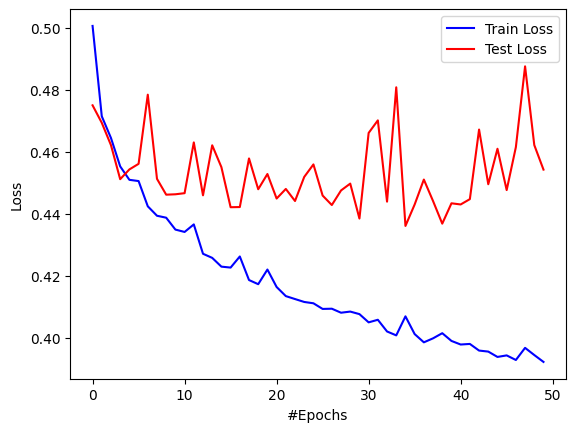

In [ ]:
model = LinearClassifier(desired_width, desired_height, 1)

fullTrainModel(model, training_dataset_binary, testing_dataset_binary, nn.BCEWithLogitsLoss(reduction='mean'), 5e-4, optimizer_type="AdamW", num_epochs=50, weight_decay=5e-2)

> The fluctuations in the test loss as opposed to the train loss and the notably lower test accuracy could indicate overfitting. I will try with train_transform and test_transform enabled to be sure, but first I will try with SGD

> Now testing with SGD optimizer

Epoch [1/50], Train Loss: 0.5203, Test Loss: 0.4906
Epoch [6/50], Train Loss: 0.4610, Test Loss: 0.4567
Epoch [11/50], Train Loss: 0.4477, Test Loss: 0.4661
Epoch [16/50], Train Loss: 0.4414, Test Loss: 0.4453
Epoch [21/50], Train Loss: 0.4351, Test Loss: 0.4438
Epoch [26/50], Train Loss: 0.4307, Test Loss: 0.4426
Epoch [31/50], Train Loss: 0.4281, Test Loss: 0.4398
Epoch [36/50], Train Loss: 0.4247, Test Loss: 0.4381
Epoch [41/50], Train Loss: 0.4224, Test Loss: 0.4397
Epoch [46/50], Train Loss: 0.4194, Test Loss: 0.4368
AIC: -5756.834713220596
BIC: 25926.463329966835

Training Accuracy: Accuracy: 13807/16870 (81.8%)

Test Accuracy: Accuracy: 3388/4220 (80.3%)


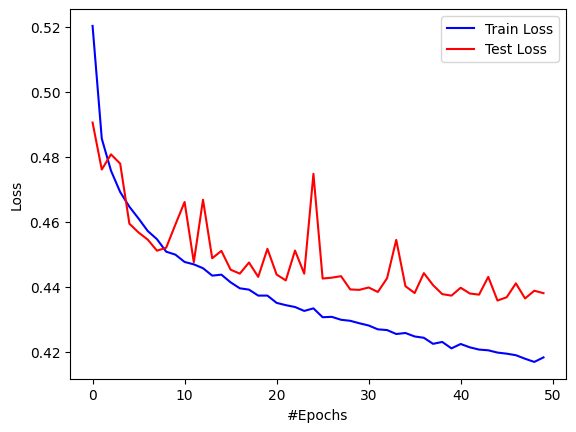

In [ ]:
model = LinearClassifier(desired_width, desired_height, 1)
fullTrainModel(model, training_dataset_binary, testing_dataset_binary, nn.BCEWithLogitsLoss(reduction='mean'), 2e-3, num_epochs=50, optimizer_type="SGD", weight_decay=5e-3)

> So with no linear transforms, both Adam and SGD overfit, and if you compare the scales on the graphs, they overfit around the same amount

In [ ]:
training_dataset_binary.set_transform(linear_train_transform)
testing_dataset_binary.set_transform(linear_test_transform)

Epoch [1/25], Train Loss: 0.6655, Test Loss: 0.6337
Epoch [6/25], Train Loss: 0.6087, Test Loss: 0.6200
Epoch [11/25], Train Loss: 0.5937, Test Loss: 0.6418
Epoch [16/25], Train Loss: 0.5840, Test Loss: 0.6779
Epoch [21/25], Train Loss: 0.5799, Test Loss: 0.6375
AIC: -10873.735869884491
BIC: 20809.56217330294

Training Accuracy: Accuracy: 11950/16870 (70.8%)

Test Accuracy: Accuracy: 2721/4220 (64.5%)


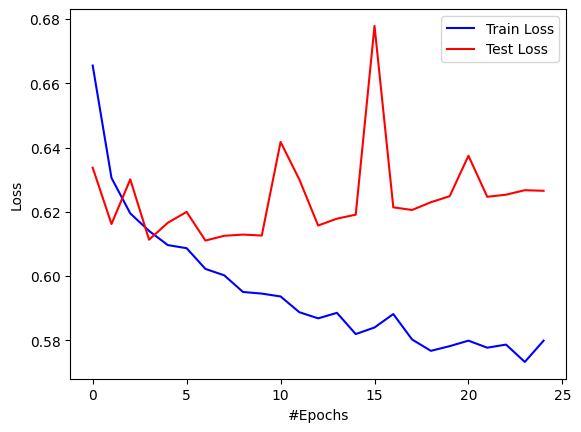

In [ ]:
model = LinearClassifier(desired_width, desired_height, 1)
fullTrainModel(model, training_dataset_binary, testing_dataset_binary, nn.BCEWithLogitsLoss(reduction='mean'), 5e-4, optimizer_type="AdamW", weight_decay=5e-2, num_epochs=25)

Epoch [1/25], Train Loss: 0.6795, Test Loss: 0.6600
Epoch [6/25], Train Loss: 0.6267, Test Loss: 0.6228
Epoch [11/25], Train Loss: 0.6141, Test Loss: 0.6190
Epoch [16/25], Train Loss: 0.6070, Test Loss: 0.6122
Epoch [21/25], Train Loss: 0.6019, Test Loss: 0.6126
AIC: -11924.095240592957
BIC: 19759.202802594475

Training Accuracy: Accuracy: 11627/16870 (68.9%)

Test Accuracy: Accuracy: 2817/4220 (66.8%)


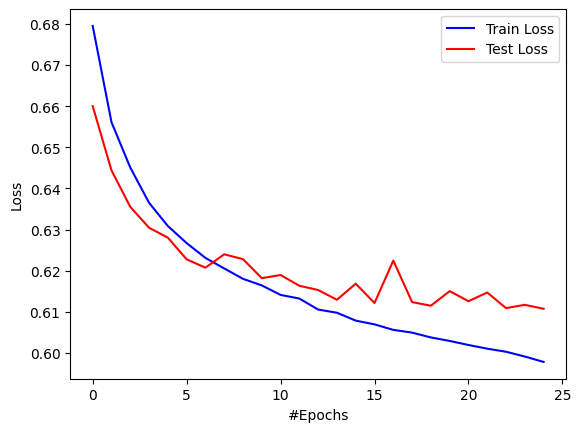

In [ ]:
model = LinearClassifier(desired_width, desired_height, 1)
fullTrainModel(model, training_dataset_binary, testing_dataset_binary, nn.BCEWithLogitsLoss(reduction='mean'), 2e-3, num_epochs=25, optimizer_type="SGD", weight_decay=5e-3)

> Chose a lower num_epochs because the training loss starts higher and starts to converge at this number of epochs

> Again, even with train_transform and test_transform enabled, both Adam and SGD clearly overfit by a noticeable amount, but not a completely devastating amount.

> In terms of linear classifiers, the train and test transforms I defined seem to largely complicate the model and yield a significant decrease in both training and testing loss and accuracy. This is possible since I have a single linear layer with img_w x img_h connections, and this could be not complex enough to capture the whole dataset. As such, I'll try using non-linear classifiers, such as a CNN

> I will try CNNs with transforms enabled (but not exclusively linear transforms) since CNNs are more complex than linear classifiers and are generally very good for image recognition

> Also, I note that linear classifiers make the assumption of linearity on the data, and thus they will not be able to decode non-linear relationships. As such, I will not test the linear classifiers with non-linear transformations.

In [ ]:
training_dataset_binary.set_transform(nonlinear_train_transform)
testing_dataset_binary.set_transform(nonlinear_test_transform)

Epoch [1/10], Train Loss: 0.6011, Test Loss: 0.4948
Results logged
Epoch [2/10], Train Loss: 0.5181, Test Loss: 0.4604
Results logged
Epoch [3/10], Train Loss: 0.4920, Test Loss: 0.4366
Results logged
Epoch [4/10], Train Loss: 0.4811, Test Loss: 0.4185
Results logged
Epoch [5/10], Train Loss: 0.4723, Test Loss: 0.4218
Results logged
Epoch [6/10], Train Loss: 0.4650, Test Loss: 0.4070
Results logged
Epoch [7/10], Train Loss: 0.4638, Test Loss: 0.4071
Results logged
Epoch [8/10], Train Loss: 0.4609, Test Loss: 0.4055
Results logged
Epoch [9/10], Train Loss: 0.4595, Test Loss: 0.3987
Results logged
Epoch [10/10], Train Loss: 0.4550, Test Loss: 0.4002
Results logged
AIC: 55786.96772360802
BIC: 328006.58559479204

Training Accuracy: Accuracy: 13706/16870 (81.2%)

Test Accuracy: Accuracy: 3488/4220 (82.7%)


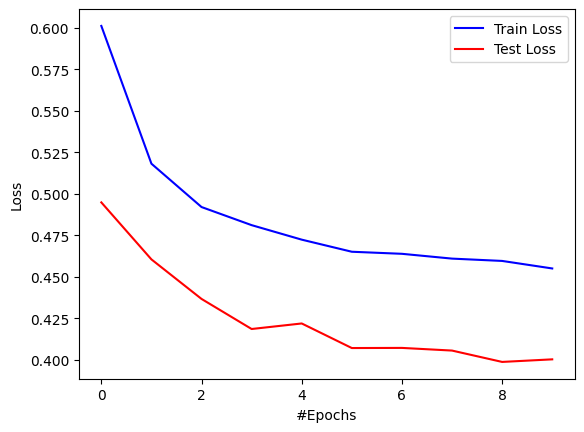

In [ ]:
CNN_model_AdamW = CNN(desired_width, desired_height, 1, dropout_probability=0.5)
fullTrainModel(CNN_model_AdamW, training_dataset_binary, testing_dataset_binary, nn.BCEWithLogitsLoss(reduction='mean'), 1e-3, optimizer_type="AdamW", num_epochs=10, weight_decay = 5e-4, print_interval=1, verbose=True)

> WOOHOO! No noticeable overfitting.

I used weight decay here as well as a non-linear model with non-linear transforms to reduce overfitting, and it worked!

> I am satisfied with this number of epochs because from the ending slope of the graph, it doesn't seem the loss will decrease much more with respect to the number of epochs. Because of this, having more epochs might even lead it to overfit!

> I also think my AIC and BIC are being calculated incorrectly if the AIC is nearly 56K compared to my ≈ -5K on the overfitted linear classifiers without transformations

> Perhaps having the transforms is responsible for largely-increased model complexity

Epoch [1/15], Train Loss: 0.6871, Test Loss: 0.6713
Results logged
Epoch [2/15], Train Loss: 0.6698, Test Loss: 0.6461
Results logged
Epoch [3/15], Train Loss: 0.6485, Test Loss: 0.6139
Results logged
Epoch [4/15], Train Loss: 0.6275, Test Loss: 0.5865
Results logged
Epoch [5/15], Train Loss: 0.6162, Test Loss: 0.6371
Results logged
Epoch [6/15], Train Loss: 0.6091, Test Loss: 0.6211
Results logged
Epoch [7/15], Train Loss: 0.5957, Test Loss: 0.5520
Results logged
Epoch [8/15], Train Loss: 0.5934, Test Loss: 0.5570
Results logged
Epoch [9/15], Train Loss: 0.5873, Test Loss: 0.5981
Results logged
Epoch [10/15], Train Loss: 0.5829, Test Loss: 0.6860
Results logged
Epoch [11/15], Train Loss: 0.5748, Test Loss: 0.5338
Results logged
Epoch [12/15], Train Loss: 0.5667, Test Loss: 0.5297
Results logged
Epoch [13/15], Train Loss: 0.5600, Test Loss: 0.5434
Results logged
Epoch [14/15], Train Loss: 0.5561, Test Loss: 0.5145
Results logged
Epoch [15/15], Train Loss: 0.5483, Test Loss: 0.5088
Resu

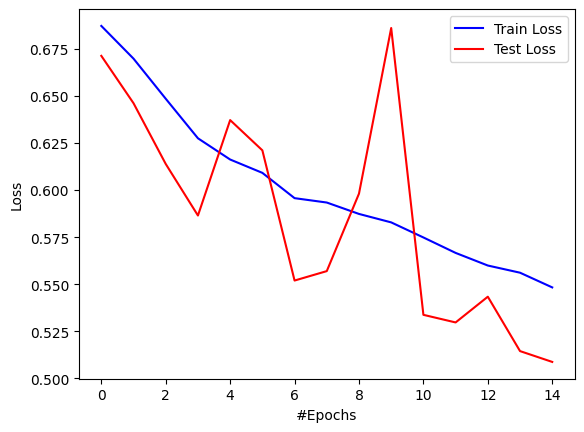

In [ ]:
CNN_model_SGD = CNN(desired_width, desired_height, 1)
fullTrainModel(CNN_model_SGD, training_dataset_binary, testing_dataset_binary, nn.BCEWithLogitsLoss(reduction='mean'), 5e-3, optimizer_type="SGD", weight_decay=1e-3, num_epochs=15, print_interval=1, verbose=True)

> I note that adaptive movement like that from Adam and AdamW are much better than a fixed momentum for this case, since we very well want to vary the momentum among iterations in this case. I can see this since the SGD-optimized model has plenty of increases in test loss over epochs. As such, for CNNs, I will stick with AdamW in the future

Epoch [1/10], Train Loss: 0.6049, Test Loss: 0.5433
Results logged
Epoch [2/10], Train Loss: 0.4789, Test Loss: 0.4751
Results logged
Epoch [3/10], Train Loss: 0.4489, Test Loss: 0.4363
Results logged
Epoch [4/10], Train Loss: 0.4355, Test Loss: 0.5911
Results logged
Epoch [5/10], Train Loss: 0.4262, Test Loss: 0.3621
Results logged
Epoch [6/10], Train Loss: 0.4119, Test Loss: 0.3792
Results logged
Epoch [7/10], Train Loss: 0.4090, Test Loss: 0.3998
Results logged
Epoch [8/10], Train Loss: 0.4003, Test Loss: 0.3338
Results logged
Epoch [9/10], Train Loss: 0.3991, Test Loss: 0.3292
Results logged
Epoch [10/10], Train Loss: 0.3892, Test Loss: 0.3988
Results logged
AIC: 4367927.610086083
BIC: 21309908.10887651

Training Accuracy: Accuracy: 13853/16870 (82.1%)

Test Accuracy: Accuracy: 3453/4220 (81.8%)


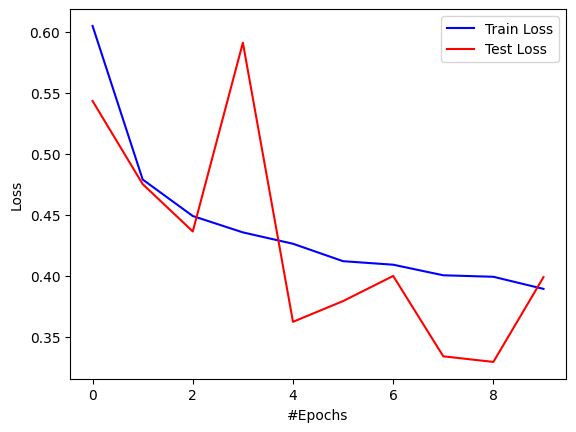

In [ ]:
HealthyCNN_model_AdamW = HealthyCNN(img_size = desired_size, num_classes=1, dropout_probability=0.65)
fullTrainModel(HealthyCNN_model_AdamW, training_dataset_binary, testing_dataset_binary, nn.BCEWithLogitsLoss(reduction='mean'), 5e-4, optimizer_type="AdamW", num_epochs=10, print_interval=1, weight_decay=1e-3, verbose=True)

> When I used dropout_probability = 0.5 and 0.7, it led to overfitting where the test loss fluctuated significantly even though the training loss kept decreasing

> Here, the test loss is still fluctuating but in the end, it is not fluctuating nearly as much as in the start. As such, I am satisfied with this number of epochs

> Tried the methods I did because I noted that in medical images, small details could matter a lot, so I wanted more control over the weights given to each of the features

> CNNs are well-suited for this task

> I am going to choose my CNN_model_AdamW because it has very good accuracy compared to the HealthyCNN model but much lower AIC and BIC and much weaker fluctuations in test loss over epochs. The last one indicates potential to overfit

In [ ]:
# Classify all 3 types of lungs, using my chosen model
chosen_model = CNN_model_AdamW

x_test = testing_dataset.input_tensor.numpy()
y_test = testing_dataset.output_tensor.numpy()

for label in [1, 2, 3]:
  unhealthy_indices_label = np.where(y_test==label)[0]
  x_test_unhealthy = x_test[unhealthy_indices_label]
  y_test_unhealthy = y_test[unhealthy_indices_label]
  unhealthy_dataset = NumpyDataset(x_test_unhealthy, y_test_unhealthy, transform=nonlinear_test_transform)
  # unhealthy_test_transform because my chosen model is a CNN that used nonlinear_test_transform as its test transform
  unhealthy_loader = torch.utils.data.DataLoader(unhealthy_dataset, batch_size=64)
  computeLabelAccuracy(chosen_model, unhealthy_loader, f"Test Accuracy for label {label}")



Test Accuracy for label 1: Accuracy: 544/677 (80.4%)

Test Accuracy for label 2: Accuracy: 238/258 (92.2%)

Test Accuracy for label 3: Accuracy: 1090/1269 (85.9%)


In [ ]:
# Classify all 3 types of lungs, using my chosen model
chosen_model_2 = HealthyCNN_model_AdamW

x_test = testing_dataset.input_tensor.numpy()
y_test = testing_dataset.output_tensor.numpy()

for label in [1, 2, 3]:
  unhealthy_indices_label = np.where(y_test==label)[0]
  x_test_unhealthy = x_test[unhealthy_indices_label]
  y_test_unhealthy = y_test[unhealthy_indices_label]
  unhealthy_dataset = NumpyDataset(x_test_unhealthy, y_test_unhealthy, transform=nonlinear_test_transform)
  # unhealthy_test_transform because my chosen model is a CNN that used nonlinear_test_transform as its test transform
  unhealthy_loader = torch.utils.data.DataLoader(unhealthy_dataset, batch_size=64)
  computeLabelAccuracy(chosen_model_2, unhealthy_loader, f"Test Accuracy for label {label}")



Test Accuracy for label 1: Accuracy: 421/677 (62.2%)

Test Accuracy for label 2: Accuracy: 217/258 (84.1%)

Test Accuracy for label 3: Accuracy: 905/1269 (71.3%)


> No, the model does not classify all 3 types of unhealthy lungs as unhealthy equally well. It classifies label 1 (COVID) worse than label3 (otherInfection, by nearly 10%) worse than label 2 (pneumonia, by nearly 10%)

> I note that these categories are not equally-represented, but surprisingly there is no clear trend in num. samples versus accuracy, so it seems to be random based on only classifying label 0 versus labels 1 through 3.

> This could be because of certain features in the overall unhealthy data being more prominent in specific labels than other labels

## Problem 2 (Healthy vs Unhealthy w/ SkLearn)

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# import PCA
from sklearn.decomposition import PCA # to extract relevant features
from sklearn.ensemble import RandomForestClassifier

> I will use PCA to do feature extraction. On top of this, I will use a non-linear model, due to the overfitting of my linear classifiers (where each feature had a connection to every other feature).

> I will not use clustering because I felt it would be not good for these images, where small details could matter a lot.

> I will first try random forests with ensemble methods. They are generally nonlinear classifiers and can capture non-linear relationships. Furthermore, they can make splits based on different categories of given feature values, rather than having to make single functions to account for many different categories of those feature values.

> Furthermore, I will initially focus on accuracy as a metric since that is easy and consistent to evaluate. When the accuracies are close, I will use my custom loss function to further penalize type 2 errors over type 1 errors

> Finally, I will set my transforms to None, so as to let the SKLearn models do all the work in classification

In [ ]:
training_dataset.set_transform(None)
testing_dataset.set_transform(None)

In [ ]:
x_train = training_dataset.input_tensor.numpy()
y_train = training_dataset_binary.output_tensor.numpy()
x_test = testing_dataset.input_tensor.numpy()
y_test = testing_dataset_binary.output_tensor.numpy()

In [ ]:
pca_95 = PCA(n_components=0.95, svd_solver='full')
pca_95.fit(x_train.reshape(x_train.shape[0], -1))

PCA(n_components=0.95, svd_solver='full')

In [ ]:
# Separate cell so I don't have to retrain the model
# get the number of features needed to explain 95%, 90%, 80%, and 75% of the variance with PCA
pca_num_features_list = []
cumulative_variance_ratio = np.cumsum(pca_95.explained_variance_ratio_)
for proportion_explained in [0.95, 0.9, 0.85, 0.8, 0.75]:
  num_pca_features = np.where(cumulative_variance_ratio >= proportion_explained)[0][0] + 1
  pca_num_features_list.append(num_pca_features)
  print(f"Number of PCA features needed to explain {proportion_explained * 100}% of the variance: {num_pca_features}")

Number of PCA features needed to explain 95.0% of the variance: 186
Number of PCA features needed to explain 90.0% of the variance: 58
Number of PCA features needed to explain 85.0% of the variance: 30
Number of PCA features needed to explain 80.0% of the variance: 20
Number of PCA features needed to explain 75.0% of the variance: 14


> I want to keep a high percent of variance explained without having too many components. As such, I will try with 80%, 85%, and 90%

In [ ]:
pca_num_components_list = [pca_num_features_list[1], pca_num_features_list[2], pca_num_features_list[3]]
train_test_pcas = []
# Compute the train and test PCAs once so that I don't have to do it over and over again
# and put them as a list into train_test_pcas, which is a list of all these lists
for num_components in pca_num_components_list:
  pca = PCA(n_components=num_components)
  x_train_pca = pca.fit_transform(x_train.reshape(x_train.shape[0], -1))
  x_test_pca = pca.transform(x_test.reshape(x_test.shape[0], -1))
  train_test_pcas.append([num_components, pca, x_train_pca, x_test_pca])

In [ ]:
def get_pca_x_train_test(num_components, train_test_pcas):
  for entry in train_test_pcas:
    if entry[0] == num_components:
      return entry[0], entry[1], entry[2], entry[3]
  print(f"No entry found with num_components = {num_components}. Making one now")
  pca = PCA(n_components=num_components)
  x_train_pca = pca.fit_transform(x_train.reshape(x_train.shape[0], -1))
  x_test_pca = pca.transform(x_test.reshape(x_test.shape[0], -1))
  train_test_pcas.append([num_components, pca, x_train_pca, x_test_pca])
  print(f"Entry added with num_components = {num_components}")
  return num_components, pca, x_train_pca, x_test_pca

In [ ]:
for n_components in pca_num_components_list:
  # check if an entry corresponding to n_components exists in train_test_pcas
  num_components, _, x_train_pca, x_test_pca = get_pca_x_train_test(n_components, train_test_pcas)

  # 3. Train your classifier on PCA-transformed training data
  classifier = RandomForestClassifier()  # Or your chosen classifier
  classifier.fit(x_train_pca, y_train.ravel()) # ravel to convert to 1D array

  # 4. Predict on PCA-transformed test data
  y_pred = classifier.predict(x_test_pca)

  # 5. Calculate accuracy score
  accuracy = accuracy_score(y_test, y_pred)

  print(f"Random Forest accuracy on test data after PCA with {num_components} components: {accuracy}")

Random Forest accuracy on test data after PCA with 58 components: 0.8319905213270142
Random Forest accuracy on test data after PCA with 30 components: 0.8398104265402844
Random Forest accuracy on test data after PCA with 20 components: 0.828909952606635


> This is decent (even with very large proportions of the variance explained by this number of components), but I think I can do better with SKLearn.

> I will also keep in mind that more components doesn't necessarily mean higher testing accuracy

> I will start with Boosting because those algorithms try to correct errors in the previous trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

for n_components in pca_num_components_list:
  n_components, pca, x_train_pca, x_test_pca = get_pca_x_train_test(n_components, train_test_pcas)
  # 1. Create the base estimator (often a Decision Tree)
  base_estimator = DecisionTreeClassifier(max_depth=1)  # You can adjust hyperparameters

  # 2. Create the AdaBoost classifier
  adaboost_classifier = AdaBoostClassifier(
      n_estimators=50,  # Number of estimators (weak learners)
      learning_rate=1.0,  # Controls the contribution of each estimator
      random_state=42,  # For reproducibility
  )

  # 3. Train the AdaBoost classifier
  adaboost_classifier.fit(x_train_pca, y_train.ravel())

  # 4. Make predictions
  y_pred_adaboost = adaboost_classifier.predict(x_test_pca)

  # 5. Calculate accuracy
  accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
  print(f"Accuracy with AdaBoost and {n_components} components: {accuracy_adaboost}")

Accuracy with AdaBoost and 58 components: 0.7651658767772512
Accuracy with AdaBoost and 30 components: 0.7651658767772512
Accuracy with AdaBoost and 20 components: 0.7580568720379147


> So decision trees don't seem to work well. As such, I will now try some of sklearn's libraries all at once in a tabular fashion

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
for n_components in pca_num_components_list:
  n_components, pca, x_train_pca, x_test_pca = get_pca_x_train_test(n_components, train_test_pcas)

  # Try different classifiers
  classifiers = {
      "Gradient Boosting": GradientBoostingClassifier(),
      "SVC (RBF Kernel)": SVC(kernel='rbf'),
      "SVC (Poly Kernel)": SVC(kernel='poly'),
      "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
      "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
      "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500),  # Adjust hyperparameters
  }

  for classifier_name, classifier in classifiers.items():
      classifier.fit(x_train_pca, y_train.ravel())
      y_pred = classifier.predict(x_test_pca)
      accuracy = accuracy_score(y_test, y_pred)
      print(f"Testing accuracy with {classifier_name} and {n_components} components: {accuracy}")
  print('\n')

Testing accuracy with Gradient Boosting and 58 components: 0.8151658767772512
Testing accuracy with SVC (RBF Kernel) and 58 components: 0.8691943127962085
Testing accuracy with SVC (Poly Kernel) and 58 components: 0.8580568720379147
Testing accuracy with KNN (k=5) and 58 components: 0.8414691943127962
Testing accuracy with KNN (k=3) and 58 components: 0.8440758293838863
Testing accuracy with MLP and 58 components: 0.845260663507109


Testing accuracy with Gradient Boosting and 30 components: 0.8120853080568721
Testing accuracy with SVC (RBF Kernel) and 30 components: 0.8597156398104265
Testing accuracy with SVC (Poly Kernel) and 30 components: 0.843127962085308
Testing accuracy with KNN (k=5) and 30 components: 0.842654028436019
Testing accuracy with KNN (k=3) and 30 components: 0.8390995260663507
Testing accuracy with MLP and 30 components: 0.8440758293838863


Testing accuracy with Gradient Boosting and 20 components: 0.8123222748815165
Testing accuracy with SVC (RBF Kernel) and 20 c

> So from here, I see that indeed KNN is not the best classifier. Gradient boosting doesn't seem to be optimal either. The best ones seem to be SVC with RBF Kernel or Poly kernel and MLP  

>

> I note that for SVC classifiers, I don't want kernel='linear' (due to poor performance of linear classifiers and me already training a polynomial kernel) and sigimoid (since we need to avoid logistic regression).

> Even though the models come from standard libraries and have very high overall accuracies. I will test for overfitting, tune hyperparameters and and use cross-validation before comparing metrics

> Finally, I will stick with the PCA from 58 components, since I feel that has a noticeably higher accuracy at not much computational cost (since I already have the PCA fitted to the data)


In [ ]:
print(pca_num_components_list[0])

58


In [ ]:
n_components, pca, x_train_pca, x_test_pca = get_pca_x_train_test(pca_num_components_list[0], train_test_pcas)

> Now to test SVC classifiers with various values of C

In [ ]:
classifier_SVC_poly_list = []
for C in [0.01, 0.1, 0.5, 1]:
  classifier_SVC_poly = SVC(kernel='poly', C=C)
  classifier_SVC_poly.fit(x_train_pca, y_train.ravel())
  y_pred_train_4 = classifier_SVC_poly.predict(x_train_pca)
  accuracy_train_4 = accuracy_score(y_train, y_pred_train_4)
  print(f"Training accuracy with SVC with poly kernel and C={C}: {accuracy_train_4}")
  y_pred_test_4 = classifier_SVC_poly.predict(x_test_pca)
  accuracy_test_4 = accuracy_score(y_test, y_pred_test_4)
  print(f"Testing accuracy with SVC with poly kernel and C={C}: {accuracy_test_4}\n")
  classifier_SVC_poly_list.append(classifier_SVC_poly)

Training accuracy with SVC with poly kernel and C=0.01: 0.7982809721398934
Testing accuracy with SVC with poly kernel and C=0.01: 0.7985781990521327

Training accuracy with SVC with poly kernel and C=0.1: 0.8378186129223474
Testing accuracy with SVC with poly kernel and C=0.1: 0.8270142180094787

Training accuracy with SVC with poly kernel and C=0.5: 0.8735032602252519
Testing accuracy with SVC with poly kernel and C=0.5: 0.8485781990521327

Training accuracy with SVC with poly kernel and C=1: 0.8903971547125074
Testing accuracy with SVC with poly kernel and C=1: 0.8580568720379147



> For SVC with poly kernel, I will stick with C=1 since that maximizes the training and testing accuracy and C-values without a big discrepancy in train and test accuracy seem to underfit

In [ ]:
classifier_SVC_rbf_list = []
for C in [0.01, 0.1, 0.5, 1]:
  classifier_SVC_rbf = SVC(kernel='rbf', C=C)
  classifier_SVC_rbf.fit(x_train_pca, y_train.ravel())
  y_pred_train_5 = classifier_SVC_rbf.predict(x_train_pca)
  accuracy_train_5 = accuracy_score(y_train, y_pred_train_5)
  print(f"Training accuracy with SVC with rbf kernel and C={C}: {accuracy_train_5}")
  y_pred_test_5 = classifier_SVC_rbf.predict(x_test_pca)
  accuracy_test_5 = accuracy_score(y_test, y_pred_test_5)
  print(f"Testing accuracy with SVC with rbf kernel and C={C}: {accuracy_test_5}\n")
  classifier_SVC_rbf_list.append(classifier_SVC_rbf)

Training accuracy with SVC with rbf kernel and C=0.01: 0.7947243627741553
Testing accuracy with SVC with rbf kernel and C=0.01: 0.7928909952606635

Training accuracy with SVC with rbf kernel and C=0.1: 0.8484884410195613
Testing accuracy with SVC with rbf kernel and C=0.1: 0.8383886255924171

Training accuracy with SVC with rbf kernel and C=0.5: 0.884588026081802
Testing accuracy with SVC with rbf kernel and C=0.5: 0.8599526066350711

Training accuracy with SVC with rbf kernel and C=1: 0.902371072910492
Testing accuracy with SVC with rbf kernel and C=1: 0.8691943127962085



> SVC with RBF kernel seems to be optimal at C=1. It also has higher training and testing accuracies than with polynomial kernel

In [ ]:
hidden_layer_sizes = [(20, 10), (35, 25), (45, 25), (60, 30), (80, 40), (100, 50)]
for hidden_layer_size in hidden_layer_sizes:
  classifier_MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_size, max_iter=500)
  classifier_MLP.fit(x_train_pca, y_train.ravel())
  y_pred_train_3 = classifier_MLP.predict(x_train_pca)
  accuracy_train_3 = accuracy_score(y_train, y_pred_train_3)
  print(f"Training accuracy with MLP and hidden layer size {hidden_layer_size}: {accuracy_train_3}")
  y_pred_test_3 = classifier_MLP.predict(x_test_pca)
  accuracy_test_3 = accuracy_score(y_test, y_pred_test_3)
  print(f"Testing accuracy with MLP and hidden layer size {hidden_layer_size}: {accuracy_test_3}\n")

Training accuracy with MLP and hidden layer size (20, 10): 0.9180201541197391
Testing accuracy with MLP and hidden layer size (20, 10): 0.852132701421801

Training accuracy with MLP and hidden layer size (35, 25): 0.9752222880853586
Testing accuracy with MLP and hidden layer size (35, 25): 0.8258293838862559

Training accuracy with MLP and hidden layer size (45, 25): 0.9888559573206877
Testing accuracy with MLP and hidden layer size (45, 25): 0.8360189573459715

Training accuracy with MLP and hidden layer size (60, 30): 0.9999407231772377
Testing accuracy with MLP and hidden layer size (60, 30): 0.8419431279620853

Training accuracy with MLP and hidden layer size (80, 40): 1.0
Testing accuracy with MLP and hidden layer size (80, 40): 0.845260663507109

Training accuracy with MLP and hidden layer size (100, 50): 1.0
Testing accuracy with MLP and hidden layer size (100, 50): 0.8481042654028436



> It seems that MLP clearly overfits on the training data for any hidden layer size, so I won't use that

> Not to mention it has somewhat lower testing accuracy than SVC with 'rbf' kernel

> I will stick with SVC with kernel='rbf' and kernel='poly' and do different train/test splits for k-fold cross validation

In [ ]:
# create a combined dataset to do different train/test splits on
x_combined_pca = np.concatenate((x_train_pca, x_test_pca), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)
combined_dataset_pca = NumpyDataset(x_combined_pca, y_combined, transform=None)
# don't see the need to use transformed images

In [ ]:
print(x_combined_pca.shape)
print(y_combined.shape)

(21090, 58)
(21090, 1)


In [ ]:
train_test_split_list_pca = []
num_desired_splits = 3
for i in range(0, num_desired_splits):
  train_dataset_pca, test_dataset_pca = sklearn.model_selection.train_test_split(combined_dataset_pca, test_size=0.2, random_state=i)
  train_test_split_list_pca.append([train_dataset_pca, test_dataset_pca])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
def get_accuracy_precision_recall_f1(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import classification_report

rbf_train_metrics = []
rbf_test_metrics = []
poly_train_metrics = []
poly_test_metrics = []

splits_completed_counter = 0 # how many iterations we have completed
num_splits = len(train_test_split_list_pca)

for train_test_split in train_test_split_list_pca:
  # extract current x and y train and test
  train_dataset_pca, test_dataset_pca = train_test_split[0], train_test_split[1]
  # Create NumpyDataset objects from the splits
  train_dataset_pca = NumpyDataset(np.array([item[0].numpy() for item in train_dataset_pca]), np.array([item[1].numpy() for item in train_dataset_pca]), transform=None)
  test_dataset_pca = NumpyDataset(np.array([item[0].numpy() for item in test_dataset_pca]), np.array([item[1].numpy() for item in test_dataset_pca]), transform=None)
  x_train_pca = train_dataset_pca.input_tensor.numpy()
  y_train = train_dataset_pca.output_tensor.numpy()
  x_test_pca = test_dataset_pca.input_tensor.numpy()
  y_test = test_dataset_pca.output_tensor.numpy()


  # fit a rbf kernel to the given train_test_split and compute metrics
  classifier_SVC_rbf = SVC(kernel='rbf', C=1)
  classifier_SVC_rbf.fit(x_train_pca, y_train.ravel())
  y_pred_train = classifier_SVC_rbf.predict(x_train_pca)
  y_pred_test = classifier_SVC_rbf.predict(x_test_pca)
  rbf_train_metrics.append(get_accuracy_precision_recall_f1(y_train, y_pred_train))
  rbf_test_metrics.append(get_accuracy_precision_recall_f1(y_test, y_pred_test))

  # fit a poly-kernel SVC to the given
  classifier_SVC_poly = SVC(kernel='poly', C=1)
  classifier_SVC_poly.fit(x_train_pca, y_train.ravel())
  y_pred_train = classifier_SVC_poly.predict(x_train_pca)
  y_pred_test = classifier_SVC_poly.predict(x_test_pca)
  poly_train_metrics.append(get_accuracy_precision_recall_f1(y_train, y_pred_train))
  poly_test_metrics.append(get_accuracy_precision_recall_f1(y_test, y_pred_test))

  splits_completed_counter += 1
  print(f"Finished iteration {splits_completed_counter} of {num_splits}\n")

Finished iteration 1 of 3

Finished iteration 2 of 3

Finished iteration 3 of 3



In [ ]:
# compute scores using predictions from CNN_AdamW model
cnn_train_metrics = []
cnn_test_metrics = []
num_components, pca_object, _, _ = get_pca_x_train_test(pca_num_components_list[0], train_test_pcas)

splits_completed_counter = 0 # how many splits we have completed
num_splits = len(train_test_split_list_pca) # how many total splits we have

for train_test_split in train_test_split_list_pca:
  # extract current x and y train and test
  train_dataset_pca, test_dataset_pca = train_test_split[0], train_test_split[1]

  # Create NumpyDataset objects from train_dataset_pca and test_dataset_pca
  train_dataset_pca = NumpyDataset(np.array([item[0].numpy() for item in train_dataset_pca]), np.array([item[1].numpy() for item in train_dataset_pca]), transform=None)
  test_dataset_pca = NumpyDataset(np.array([item[0].numpy() for item in test_dataset_pca]), np.array([item[1].numpy() for item in test_dataset_pca]), transform=None)
  # will apply transform after applying inverse transform and reshaping data
  # since inverse_transform returns flattened data and the transforms expect image format

  # get the original non-pca transformed X data
  x_train_original = pca_object.inverse_transform(train_dataset_pca.input_tensor.numpy())
  x_test_original = pca_object.inverse_transform(test_dataset_pca.input_tensor.numpy())

  # reshape the train data to the desired shape for the CNN
  x_train_original = x_train_original.reshape(-1, 1, desired_width, desired_height)
  x_test_original = x_test_original.reshape(-1, 1, desired_width, desired_height)

  # Create NumpyDataset objects from the splits, being sure to set nonlinear transforms
  train_dataset_original = NumpyDataset(x_train_original, np.array([item[1].numpy() for item in train_dataset_pca]), transform=nonlinear_train_transform)
  test_dataset_original = NumpyDataset(x_test_original, np.array([item[1].numpy() for item in test_dataset_pca]), transform=nonlinear_test_transform)

  # Get the data loaders for the CNN
  train_loader_original = torch.utils.data.DataLoader(train_dataset_original, batch_size=64)
  test_loader_original = torch.utils.data.DataLoader(test_dataset_original, batch_size=64)

  # Now predict using the CNN
  y_train_binary_pred = []
  for batch_x, _ in train_loader_original:
      y_train_binary_pred.extend(chosen_model(batch_x).detach().numpy().flatten())
  y_train_binary_pred = np.array(y_train_binary_pred)

  y_test_binary_pred = []
  for batch_x, _ in test_loader_original:
      y_test_binary_pred.extend(chosen_model(batch_x).detach().numpy().flatten())
  y_test_binary_pred = np.array(y_test_binary_pred)

  # Get the true labels
  y_train_binary = train_dataset_original.output_tensor.numpy()
  y_test_binary = test_dataset_original.output_tensor.numpy()

  # Convert predictions to binary values so my metric functions work
  y_train_binary_pred = (y_train_binary_pred > 0).astype(int)
  y_test_binary_pred = (y_test_binary_pred > 0).astype(int)

  # Now get metrics on  and y_test compared to predictions
  cnn_train_metrics.append(get_accuracy_precision_recall_f1(y_train_binary, y_train_binary_pred))
  cnn_test_metrics.append(get_accuracy_precision_recall_f1(y_test_binary, y_test_binary_pred))

  splits_completed_counter += 1
  print(f"Finished iteration {splits_completed_counter} of {num_splits}\n")

Finished iteration 1 of 3

Finished iteration 2 of 3

Finished iteration 3 of 3



In [ ]:
# Average of SVC (polynomial kernel and rbf kernel) metrics
num_splits = len(train_test_split_list_pca)
avg_rbf_train_metrics = np.sum(np.array(rbf_train_metrics), axis=0) / num_splits
avg_rbf_test_metrics = np.sum(np.array(rbf_test_metrics), axis=0) / num_splits
avg_poly_train_metrics = np.sum(np.array(poly_train_metrics), axis=0) / num_splits
avg_poly_test_metrics = np.sum(np.array(poly_test_metrics), axis=0) / num_splits
print("Metrics in order are: [accuracy, precision, recall, f1]")
print(f"Average train metrics for rbf kernel: {avg_rbf_train_metrics}")
print(f"Average test metrics for rbf kernel: {avg_rbf_test_metrics}")
print(f"Average train metrics for poly kernel: {avg_poly_train_metrics}")
print(f"Average test metrics for poly kernel: {avg_poly_test_metrics}")

Metrics in order are: [accuracy, precision, recall, f1]
Average train metrics for rbf kernel: [0.90101944 0.91505556 0.89103969 0.90288731]
Average test metrics for rbf kernel: [0.8724514  0.88804003 0.8643524  0.87603563]
Average train metrics for poly kernel: [0.88967915 0.87989886 0.91066609 0.89501771]
Average test metrics for poly kernel: [0.85174648 0.845904   0.87512147 0.86024781]


In [ ]:
# Average metrics of my CNN
avg_cnn_train_metrics = np.sum(np.array(cnn_train_metrics), axis=0) / num_splits
avg_cnn_test_metrics = np.sum(np.array(cnn_test_metrics), axis=0) / num_splits
print("Metrics in order are: [accuracy, precision, recall, f1]")
print(f"Average train metrics for CNN: {avg_cnn_train_metrics}")
print(f"Average test metrics for CNN: {avg_cnn_test_metrics}")

Metrics in order are: [accuracy, precision, recall, f1]
Average train metrics for CNN: [0.72038486 0.67952792 0.86781668 0.76221152]
Average test metrics for CNN: [0.75264738 0.7112156  0.88496721 0.78862677]


> Over 3 different train-test splits, my CNN had significantly worse metrics (from accuracy, precision, recall, and f1) than both SVC with polynomial kernel and rbf kernel. The only upside of my CNN is that it doesn't have lower test metrics than train metrics, unlike my SVCs. I will note, however, that my CNN is stronger at predicting positive samples (unhealthy, since the default positive label is 1) than it is at predicting healthy labels.

> My SVC

> (These may not be updated for the most recent occurrence of these cells in my notebook) Train metrics for CNN, SVC(poly), SVC(rbf):

>> accuracy 0.720, 0.890, 0.901

>> precision 0.679, 0.880, 0.915

>> recall 0.867, 0.910, 0.891

>> f1 0.762, 0.895, 0.903

> Test metrics for CNN, SVC(poly), SVC(rbf):

>> accuracy: 0.753, 0.846, 0.888

>> precision: 0.711, 0.849, 0.893

>> recall: 0.885, 0.875, 0.864

>> f1: 0.789, 0.860, 0.876

> Because I want to focus most on recall (since I want to minimize type 2 errors) on testing data and there isn't much of a difference between SVC with poly and rbf kernel on other metrics, I will choose the SVC with poly kernel

## Problem 3 (Multiclass Classification w/ Disease Types)

> From my last problem, since I haven't really looked into penalizing type 2 errors for certain kinds of infections over others, I will stick with recall as my most important metric.

In [ ]:
# Making sure my training_dataset and testing_dataset NumpyDataset-s contain the original preprocessed non-binary data
print(f"Shape of original features: f{np.shape(training_dataset.input_tensor)}")
print(f"Shape of original labels: f{np.shape(training_dataset.output_tensor)}")
print(f"original labels: {training_dataset.output_tensor}")
print(f"Entries of label 2: {training_dataset.output_tensor[training_dataset.output_tensor==2]}")

Shape of original features: ftorch.Size([16870, 64, 64])
Shape of original labels: ftorch.Size([16870, 1])
original labels: tensor([[1.],
        [3.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
Entries of label 2: tensor([2., 2., 2.,  ..., 2., 2., 2.])


In [ ]:
# Set x_train/test and y_train/test to the input/output tensors of training_dataset and testing_dataset
# so it is easy to work with and more readable
x_train = training_dataset.input_tensor.numpy()
y_train = training_dataset.output_tensor.numpy()
x_test = testing_dataset.input_tensor.numpy()
y_test = testing_dataset.output_tensor.numpy()

In [ ]:
unique_labels, label_counts = np.unique(y_train, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Number of training samples with label {label}: {count}")

Number of training samples with label 0.0: 8162
Number of training samples with label 1.0: 2917
Number of training samples with label 2.0: 1087
Number of training samples with label 3.0: 4704


> Yep, this is indeed the original, outlier-removed dataset

> Now, I remember that label==2.0 is underrepresented in the dataset, so I will do data sampling to make that more represented in the dataset

> I also feel that label 3.0 with otherInfection should be slightly higher than label 1.0 and 2.0 because of the fact that there is a wider range of lung infections that are both non-COVID and non-pneumonia

> As such, I will aim to make both label 1.0 and label 2.0 have 3500 samples each, so that they are fairly represented.

> I will keep label 0.0 with over 8000 samples since it is a single category and I feel the range of healthy lung images is wider than that for any single infection category.

In [ ]:
def balance_dataset_labels(dataset, label_counts):
    """Balances the dataset to have specified sample counts for all labels.

    Args:
        dataset: The original NumpyDataset object.
        label_counts: A dictionary where keys are labels (0.0, 1.0, 2.0, 3.0)
                      and values are the desired sample counts for each label.

    Returns:
        A new NumpyDataset object with the balanced data.
    """

    all_selected_indices = []

    for label in [0, 3]: # keep the samples where the labels are not in label_counts
      label_indices = np.where(dataset.output_tensor.numpy() == label)[0]
      all_selected_indices.extend(label_indices)

    for label, count in label_counts.items():
        # Get indices of samples with the current label
        label_indices = np.where(dataset.output_tensor.numpy() == label)[0]

        # If the desired count exceeds the available samples, upsample with replacement
        if count > len(label_indices):
            # Calculate how many samples to add
            samples_to_add = count - len(label_indices)

            # Upsample with replacement
            upsampled_indices = np.random.choice(label_indices, size=samples_to_add, replace=True)

            # Combine original and upsampled indices
            selected_label_indices = np.concatenate([label_indices, upsampled_indices])
        else:
            # If enough samples, select without replacement
            selected_label_indices = np.random.choice(label_indices, size=count, replace=False)

        # Add the selected indices to the overall list
        all_selected_indices.extend(selected_label_indices)

    # Create a new dataset with the balanced data
    balanced_dataset = NumpyDataset(
        dataset.input_tensor.numpy()[all_selected_indices],
        dataset.output_tensor.numpy()[all_selected_indices],
        transform=dataset.transform  # Preserve the original transform
    )

    return balanced_dataset

In [ ]:
label_counts = {
    1: 3500,
    2: 3500,
}
balanced_training_dataset = balance_dataset_labels(training_dataset, label_counts)

In [ ]:
y_train_balanced = balanced_training_dataset.output_tensor.numpy()
unique_labels, label_counts = np.unique(y_train_balanced, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Number of training samples with label {label}: {count}")

Number of training samples with label 0.0: 8162
Number of training samples with label 1.0: 3500
Number of training samples with label 2.0: 3500
Number of training samples with label 3.0: 4704


In [ ]:
if 'training_dataset_unbalanced' not in globals():
  training_dataset_unbalanced = training_dataset
# no need to do this for testing dataset since we aren't modifying that
# store the original training dataset in case we need to access it later

In [ ]:
training_dataset = NumpyDataset(balanced_training_dataset.input_tensor.numpy(), balanced_training_dataset.output_tensor.numpy(), multiclass=True)
testing_dataset = NumpyDataset(testing_dataset.input_tensor.numpy(), testing_dataset.output_tensor.numpy(), multiclass=True)
x_train, y_train = training_dataset.input_tensor.numpy(), training_dataset.output_tensor.numpy()
x_test, y_test = testing_dataset.input_tensor.numpy(), testing_dataset.output_tensor.numpy()

In [ ]:
x_train_sums_2 = np.sum(x_train, axis=(1, 2)) # per-image sum of pixel values of train images
global_mean_2 = np.mean(x_train_sums_2) # global mean of per-image sums
global_std_2 = np.std(x_train_sums_2) # global std of per-image sums

# x_test is unmodified and thus so is x_test_sums

outlier_train_indices = np.where(np.abs((x_train_sums_2 - global_mean_2) / global_std_2) > 3)
print(f"Number of outlier training samples: {len(outlier_train_indices[0])}")

Number of outlier training samples: 12


In [ ]:
print("BEFORE \n ")
print(x_train.shape)
print(y_train.shape)
x_train = np.delete(x_train, outlier_train_indices, axis=0)
y_train = np.delete(y_train, outlier_train_indices, axis=0)
print("\n AFTER")
print(x_train.shape)
print(y_train.shape)

BEFORE 
 
(19866, 64, 64)
(19866, 1)

 AFTER
(19854, 64, 64)
(19854, 1)


In [ ]:
# Making sure all the samples > 3 stds from the mean of the previous x_train and y_train were removed
new_outlier_train_indices = np.where(np.abs((x_train - global_mean_2) / global_std_2) > 3)
print(f"Number of samples w/ np.abs > 3 WRT the data before outlier removal: {new_outlier_train_indices[0].shape}")
# If we did the last part correctly, this should print 0

Number of samples w/ np.abs > 3 WRT the data before outlier removal: (0,)


> I do note that the training_dataset and testing_dataset are with outliers removed. I will stick with this because data sampling is just adding more samples with the same original data as previous samples.

> Now with data equally-represented, I will first try a CNN very similar to that from problem 1 (but outputting 4 values corresponding to the class probabilities), noting that fullTrainModel does indeed use PyTorch gradient descent.

> Also, because this is multi-class classification and not binary classification, I will choose a new loss function. In this case, I have chosen CrossEntropyLoss

In [ ]:
training_dataset = NumpyDataset(x_train, y_train, transform=None, multiclass=True)
testing_dataset = NumpyDataset(x_test, y_test, transform=None, multiclass=True)

In [ ]:
training_dataset.set_transform(nonlinear_train_transform)
testing_dataset.set_transform(nonlinear_test_transform)

Data loaded
Epoch [1/15], Train Loss: 1.0859, Test Loss: 0.7952
Epoch [2/15], Train Loss: 0.8569, Test Loss: 0.6947
Epoch [3/15], Train Loss: 0.7821, Test Loss: 0.6730
Epoch [4/15], Train Loss: 0.7390, Test Loss: 0.6160
Epoch [5/15], Train Loss: 0.7112, Test Loss: 0.6166
Epoch [6/15], Train Loss: 0.6932, Test Loss: 0.5788
Epoch [7/15], Train Loss: 0.6802, Test Loss: 0.5640
Epoch [8/15], Train Loss: 0.6644, Test Loss: 0.5442
Epoch [9/15], Train Loss: 0.6542, Test Loss: 0.5373
Epoch [10/15], Train Loss: 0.6490, Test Loss: 0.5425
Epoch [11/15], Train Loss: 0.6362, Test Loss: 0.5388
Epoch [12/15], Train Loss: 0.6372, Test Loss: 0.5203
Epoch [13/15], Train Loss: 0.6275, Test Loss: 0.5691
Epoch [14/15], Train Loss: 0.6210, Test Loss: 0.5339
Epoch [15/15], Train Loss: 0.6140, Test Loss: 0.5009
AIC: 191258.7141456604
BIC: 857347.2526628977

Training Accuracy: Accuracy: 15539/19854 (78.3%)

Test Accuracy: Accuracy: 3417/4220 (81.0%)


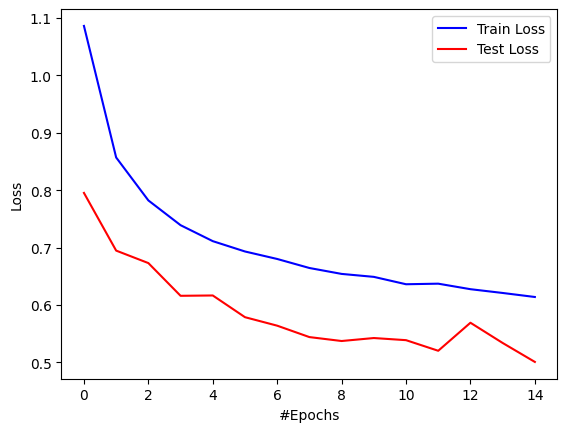

In [ ]:
MulticlassCNN_model_AdamW = MulticlassCNN(desired_width, desired_height, numClasses=4)
multiclass_fullTrainModel(MulticlassCNN_model_AdamW, training_dataset, testing_dataset, multiclass_loss_function, 5e-4, optimizer_type="AdamW", num_epochs=15, print_interval=1, weight_decay=1e-3)

> I am happy with 15 epochs because I note that the loss starts to fluctuate without much decrease beyond this point.

In [ ]:
chosen_model = MulticlassCNN_model_AdamW

In [ ]:
# prediction accuracy of chosen_model
y_pred = []
with torch.no_grad():
  for data in torch.utils.data.DataLoader(testing_dataset, batch_size=64):
    output = chosen_model(data[0])
    y_pred.extend(output.numpy())
multiclass_computeLabelAccuracy(chosen_model, torch.utils.data.DataLoader(testing_dataset, batch_size=64), return_accuracy=False);


: Accuracy: 3417/4220 (81.0%)


In [ ]:
# Get the accuracy on each label
for label in range(0, 4):
  label_indices = np.where(testing_dataset.output_tensor.numpy() == label)[0]  # Get indices of samples with label 2

  # Filter input and target data using the indices
  filtered_input_data = testing_dataset.input_tensor[label_indices]
  filtered_target_output = testing_dataset.output_tensor[label_indices]

  # Create a new dataset with the filtered data
  filtered_dataset = NumpyDataset(filtered_input_data.numpy(), filtered_target_output.numpy(), transform=None, multiclass=True)
  filtered_dataset.set_transform(nonlinear_test_transform)

  # Now calculate accuracy on the filtered dataset

  y_pred = chosen_model(filtered_dataset.input_tensor)
  predicted_classes = torch.argmax(y_pred, dim=1)
  num_correct = torch.sum(predicted_classes == filtered_dataset.output_tensor).item()
  #accuracy = num_correct / len(filtered_dataset.output_tensor)
  #print(num_correct)
  #print(len(filtered_dataset.output_tensor))
  #print(f"Accuracy for label {label}: {accuracy}")

  multiclass_computeLabelAccuracy(chosen_model, torch.utils.data.DataLoader(filtered_dataset, batch_size=64), label_text=f"label {label}", return_accuracy=False);


label 0: Accuracy: 1849/2016 (91.7%)

label 1: Accuracy: 405/677 (59.8%)

label 2: Accuracy: 229/258 (88.8%)

label 3: Accuracy: 934/1269 (73.6%)


## Part 4 (Model Evaluation)

Label 0: Max predicted probability = 0.9968 at index 4115


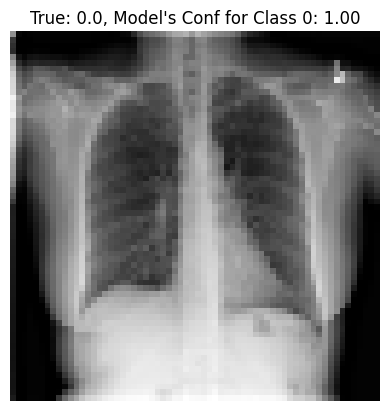

Label 1: Max predicted probability = 0.9981 at index 121


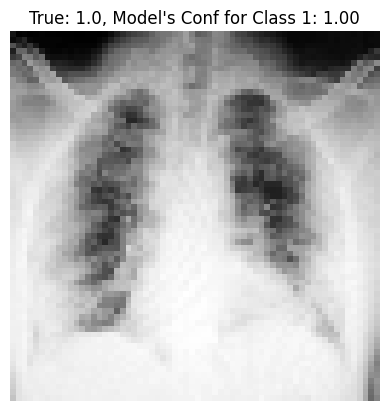

Label 2: Max predicted probability = 0.9999 at index 1954


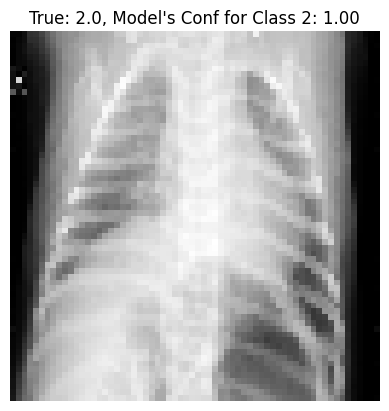

Label 3: Max predicted probability = 0.9996 at index 654


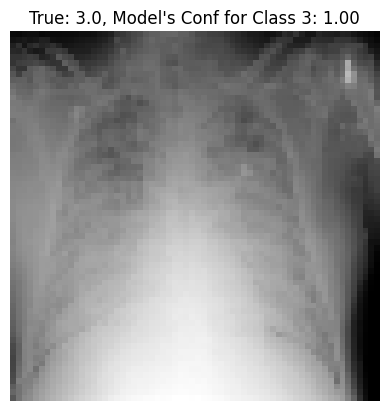

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

chosen_model.eval()
all_probs = []
chosen_indices = []

# Keep track of indices relative to the dataset
all_pred_indices = []

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=64)

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        outputs = chosen_model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs)
        # Compute indices of this batch within the full dataset
        start_idx = batch_idx * 64
        batch_size = inputs.shape[0]
        all_pred_indices.extend(range(start_idx, start_idx + batch_size))

# Concatenate predictions
all_probs = torch.cat(all_probs, dim=0).cpu().numpy()

# Now find the max-confidence sample per class and show the original image
for label in range(4):
    class_probs = all_probs[:, label]
    max_idx = np.argmax(class_probs)
    dataset_idx = all_pred_indices[max_idx]  # actual index in testing_dataset
    chosen_indices.append(dataset_idx)
    confidence = class_probs[max_idx]

    # Original image from dataset (no transform)
    original_img = testing_dataset.input_tensor[dataset_idx].squeeze().numpy()
    true_label = testing_dataset.output_tensor[dataset_idx].item()

    print(f"Label {label}: Max predicted probability = {confidence:.4f} at index {dataset_idx}")

    plt.imshow(original_img, cmap='gray')
    plt.title(f"True: {true_label}, Model's Conf for Class {label}: {confidence:.2f}")
    plt.axis('off')
    plt.show()


> Okay, these images are very blurry when seeing them in large. Because I don't want to quadruple the training time by using 128x128 instead of 64x64, I will zoom in to these images to visualize them.

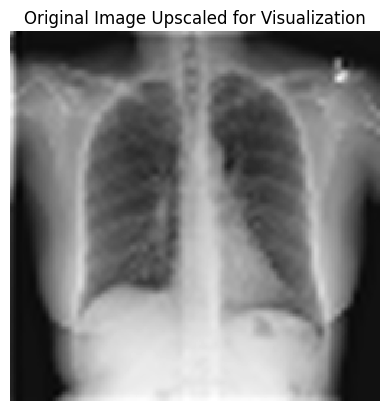

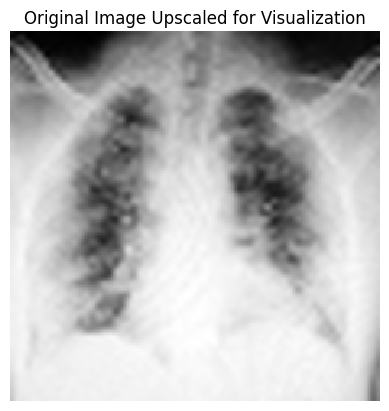

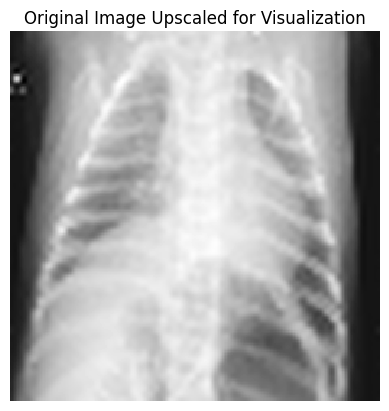

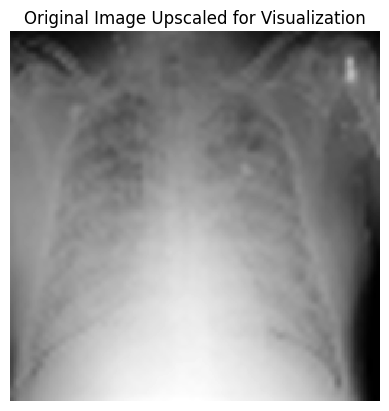

In [ ]:
from scipy.ndimage import zoom

chosen_images = testing_dataset.input_tensor[chosen_indices]
original_imgs = chosen_images.numpy()

# Upscale just for showing
zoom_factor = 4  # Try 2x or 4x for better clarity
for image in original_imgs:
  img_to_show = zoom(image, zoom_factor)
  plt.imshow(img_to_show, cmap='gray', interpolation='nearest')
  plt.title("Original Image Upscaled for Visualization")
  plt.axis('off')
  plt.show()

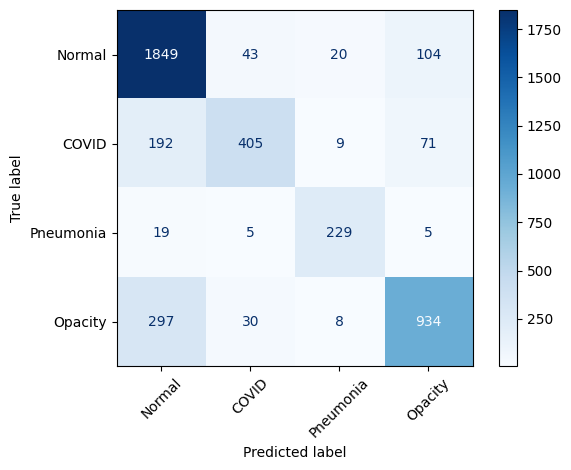

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

chosen_model.eval()
y_true = []
y_pred = []

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=64)

with torch.no_grad():
  for inputs, labels in test_loader:
    outputs = chosen_model(inputs)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes.numpy())

# Now for the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Normal", "COVID", "Pneumonia", "Opacity"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.tight_layout()
plt.show()

> Here, the 3 most common cases of misclassifications are: true label = opacity and predicted = normal; true label = COVID and predicted = normal; and true label = COVID but predicted = opacity

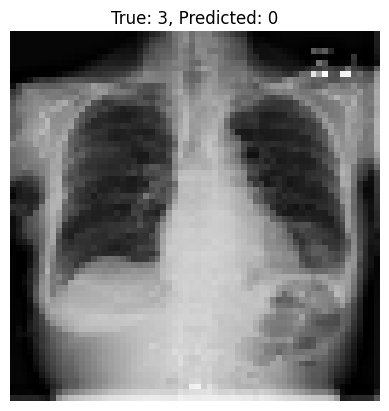

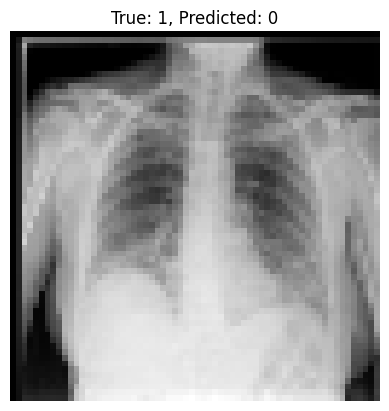

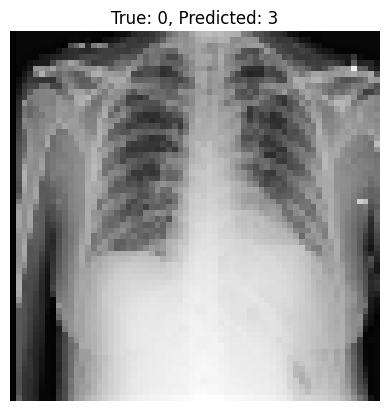

In [ ]:
target_cases = [
    (3, 0), # true = opacity and predicted = normal
    (1, 0), # true = COVID and predicted = normal
    (0, 3) # true = normal and predicted = opacity
]

all_indices = np.arange(len(y_true))

shown = set()
for true_label, pred_label in target_cases:
    for i, (t, p) in enumerate(zip(y_true, y_pred)):
        if t == true_label and p == pred_label:
            idx = all_indices[i]
            img = testing_dataset.input_tensor[idx].squeeze().numpy()

            plt.imshow(img, cmap='gray')
            plt.title(f"True: {true_label}, Predicted: {pred_label}")
            plt.axis('off')
            plt.show()

            shown.add((true_label, pred_label))
            break  # only show the first match for each case